In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from typing import List, Tuple, Dict, Optional
from itertools import product
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings('ignore')

datapath = r"C:\Users\1jafa\OneDrive\Documents\Quant\Sandbox\ivb\ETHUSDT.csv"
df = pd.read_csv(datapath, parse_dates=['timestamp'])
df.set_index('timestamp', inplace=True)
df = df.loc['2023-01-01':'2025-12-01']

### Rank Based Strat

In [59]:
def get_r_norm(df, horizons, vol_span):
    for n in horizons:
        df[f'r_{n}'] = df['close'].pct_change(periods=n)

    df['returns_1h'] = df['close'].pct_change()
    df['volatility'] = df['returns_1h'].ewm(span=vol_span).std()
    for n in horizons:
        df[f'r_norm_{n}'] = df[f'r_{n}'] / df['volatility'].shift(1)

    return df

In [60]:
def calc_rank(df, horizons, rank_window):
    rank_window = rank_window*24 # rank window - 15 days x 24 hrs

    for n in horizons:
        returns = df[f'r_norm_{n}']  # or df[f'r_{n}']

        df[f'rank_long_{n}'] = returns.rolling(rank_window).apply(
            lambda x: (x.iloc[-1] > x[x > 0]).mean() if (x > 0).sum() > 10 else 0.5)
        
        df[f'rank_short_{n}'] = (-returns).rolling(rank_window).apply(
            lambda x: (x.iloc[-1] > x[x > 0]).mean() if (x > 0).sum() > 10 else 0.5)
    return df

In [61]:
def get_scores(df, horizons, weights):
    df['S_long'], df['S_short'] = 0, 0

    for i, n in enumerate(horizons):
        df['S_long'] += weights[i] * df[f'rank_long_{n}']
        df['S_short'] += weights[i] * df[f'rank_short_{n}']
    return df

In [62]:
def trade(df, q_e, q_x, max_hold_hours):
    df['position'], df['entry_time'] = 0, pd.NaT

    positions, entry_times, current_position, current_entry_time = [], [], 0, pd.NaT

    for i in range(len(df)):
        current_time = df.index[i]
        s_long = df['S_long'].iloc[i] if not np.isnan(df['S_long'].iloc[i]) else 0
        s_short = df['S_short'].iloc[i] if not np.isnan(df['S_short'].iloc[i]) else 0
        
        # Check if we need to exit due to time limit
        if current_position != 0 and not pd.isna(current_entry_time):
            hours_held = (current_time - current_entry_time).total_seconds() / 3600
            if hours_held >= max_hold_hours:
                current_position = 0
                current_entry_time = pd.NaT
        
        # Exit logic based on scores
        if current_position == 1 and s_long < q_x:
            current_position = 0
            current_entry_time = pd.NaT
        elif current_position == -1 and s_short < q_x:
            current_position = 0
            current_entry_time = pd.NaT
        
        # Entry logic (only if we're flat)
        if current_position == 0:
            if s_long > q_e:
                current_position = 1
                current_entry_time = current_time
            elif s_short > q_e:
                current_position = -1
                current_entry_time = current_time
        
        positions.append(current_position)
        entry_times.append(current_entry_time)

    df['position'] = positions
    df['entry_time'] = entry_times

    return df

In [63]:
def apply_transaction_costs(df, cost=0.0004):
    df['position_shift'] = df['position'].shift(1).fillna(0)
    df['trade_size'] = (df['position'] - df['position_shift']).abs()
    df['transaction_cost'] = df['trade_size'] * cost
    df['strategy_returns'] -= df['transaction_cost']
    df.drop(['position_shift', 'trade_size', 'transaction_cost'], axis=1, inplace=True)
    return df

In [64]:
def calculate_mdd(cumulative_returns):
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    return drawdown.min()

### Walk-Forward

In [ ]:
datapath = r"C:\Users\1jafa\OneDrive\Documents\Quant\Sandbox\ivb\ETHUSDT.csv"
df_full = pd.read_csv(datapath, parse_dates=['timestamp'])
df_full.set_index('timestamp', inplace=True)
df_full = df_full.loc['2023-01-01':'2025-12-01']

rank_window_list = [7, 15]
horizons_list = [[24, 48, 96]]
vol_span_list = [48, 24]
weights_list = [
    [0.50, 0.30, 0.20],
    [0.40, 0.30, 0.30],
    # [0.3, 0.4, 0.30],
    [0.30, 0.30, 0.40],
    [0.20, 0.30, 0.50],
]
q_e_list = [0.7, 0.8]
q_x_list = [0.2, 0.3]
max_hold_hours_list = [24, 36, 48, 60]

In [158]:
start_date, end_date = pd.to_datetime('2023-01-01'), pd.to_datetime('2025-12-01')
is_length = relativedelta(months=12)
oos_length = relativedelta(months=3)
step = relativedelta(months=3)

current_start = start_date
oos_dfs = []

In [159]:
while current_start + is_length + oos_length <= end_date:
    is_start = current_start
    is_end = is_start + is_length - pd.Timedelta(1, 'h')
    oos_start = is_end + pd.Timedelta(1, 'h')
    oos_end = oos_start + oos_length - pd.Timedelta(1, 'h')
    
    df_train = df.loc[is_start:is_end].copy()
    results = []
    for horizons, vol_span, rank_window in product(horizons_list, vol_span_list, rank_window_list):
        df_norm = get_r_norm(df_train, horizons, vol_span)
        df_rank = calc_rank(df_norm, horizons, rank_window)
        for weights, q_e, q_x, max_hold_hours in product(weights_list, q_e_list, q_x_list, max_hold_hours_list):
            if q_x >= q_e:
                continue
            df_scores = get_scores(df_rank, horizons, weights)
            df_trade = trade(df_scores, q_e, q_x, max_hold_hours)
            df_trade['strategy_returns'] = df_trade['position'].shift(1) * df_trade['returns_1h']
            df_trade = apply_transaction_costs(df_trade)
            df_trade['cumulative_strategy'] = (1 + df_trade['strategy_returns']).cumprod()
            final_ret = df_trade['cumulative_strategy'].iloc[-1]
            mean_ret = df_trade['strategy_returns'].mean()
            std_ret = df_trade['strategy_returns'].std()
            sharpe = mean_ret / std_ret * np.sqrt(8760) if std_ret > 0 else np.nan
            mdd = calculate_mdd(df_trade['cumulative_strategy'])
            results.append({
                'horizons': horizons,
                'vol_span': vol_span,
                'rank_window': rank_window,
                'weights': weights,
                'q_e': q_e,
                'q_x': q_x,
                'max_hold_hours': max_hold_hours,
                'final_ret': final_ret,
                'sharpe': sharpe,
                'mdd': mdd
            })
    
    results_df = pd.DataFrame(results)
    best_params = results_df.loc[results_df['sharpe'].idxmax()].to_dict()
    
    df_oos = df.loc[oos_start:oos_end].copy()
    df_norm_oos = get_r_norm(df_oos, best_params['horizons'], best_params['vol_span'])
    df_rank_oos = calc_rank(df_norm_oos, best_params['horizons'], best_params['rank_window'])
    df_scores_oos = get_scores(df_rank_oos, best_params['horizons'], best_params['weights'])
    df_trade_oos = trade(df_scores_oos, best_params['q_e'], best_params['q_x'], best_params['max_hold_hours'])
    df_trade_oos['strategy_returns'] = df_trade_oos['position'].shift(1) * df_trade_oos['returns_1h']
    df_trade_oos = apply_transaction_costs(df_trade_oos)
    df_trade_oos['cumulative_strategy'] = (1 + df_trade_oos['strategy_returns']).cumprod()
    
    oos_final_ret = df_trade_oos['cumulative_strategy'].iloc[-1]
    oos_mean_ret = df_trade_oos['strategy_returns'].mean()
    oos_std_ret = df_trade_oos['strategy_returns'].std()
    oos_sharpe = oos_mean_ret / oos_std_ret * np.sqrt(8760) if oos_std_ret > 0 else np.nan
    oos_mdd = calculate_mdd(df_trade_oos['cumulative_strategy'])
    
    print(f"OOS {oos_start} to {oos_end}: Ret {oos_final_ret:.3f}, Sharpe {oos_sharpe:.3f}, MDD {oos_mdd:.3f}")
    print(f"Best Params: {best_params}")
    
    oos_dfs.append(df_trade_oos)
    
    current_start += step

OOS 2024-01-01 00:00:00 to 2024-03-31 23:00:00: Ret 1.114, Sharpe 1.309, MDD -0.164
Best Params: {'horizons': [24, 48, 96], 'vol_span': 48, 'rank_window': 15, 'weights': [0.5, 0.3, 0.2], 'q_e': 0.7, 'q_x': 0.3, 'max_hold_hours': 48, 'final_ret': 1.0931394657264992, 'sharpe': 0.4482304365062984, 'mdd': -0.19273377925817595}
OOS 2024-04-01 00:00:00 to 2024-06-30 23:00:00: Ret 0.938, Sharpe -1.126, MDD -0.109
Best Params: {'horizons': [24, 48, 96], 'vol_span': 48, 'rank_window': 30, 'weights': [0.4, 0.3, 0.3], 'q_e': 0.8, 'q_x': 0.2, 'max_hold_hours': 48, 'final_ret': 1.1726278141699258, 'sharpe': 0.6842171089054391, 'mdd': -0.21913454883392797}
OOS 2024-07-01 00:00:00 to 2024-09-30 23:00:00: Ret 1.133, Sharpe 1.497, MDD -0.127
Best Params: {'horizons': [24, 48, 96], 'vol_span': 48, 'rank_window': 30, 'weights': [0.5, 0.3, 0.2], 'q_e': 0.8, 'q_x': 0.2, 'max_hold_hours': 48, 'final_ret': 1.2563391448092232, 'sharpe': 0.8518892430064918, 'mdd': -0.20403167152887441}
OOS 2024-10-01 00:00:00 

In [160]:
merged_oos = pd.concat(oos_dfs)
merged_oos['cumulative_strategy'] = (1 + merged_oos['strategy_returns']).cumprod()
total_sharpe = (merged_oos['strategy_returns'].mean() / merged_oos['strategy_returns'].std()) * np.sqrt(8760)
total_ret = merged_oos['cumulative_strategy'].iloc[-1]
total_mdd = calculate_mdd(merged_oos['cumulative_strategy'])

print(f"Total OOS Sharpe: {total_sharpe:.2f}, Ret: {total_ret:.2f}, MDD: {total_mdd:.2f}")

Total OOS Sharpe: 1.16, Ret: 1.85, MDD: -0.23


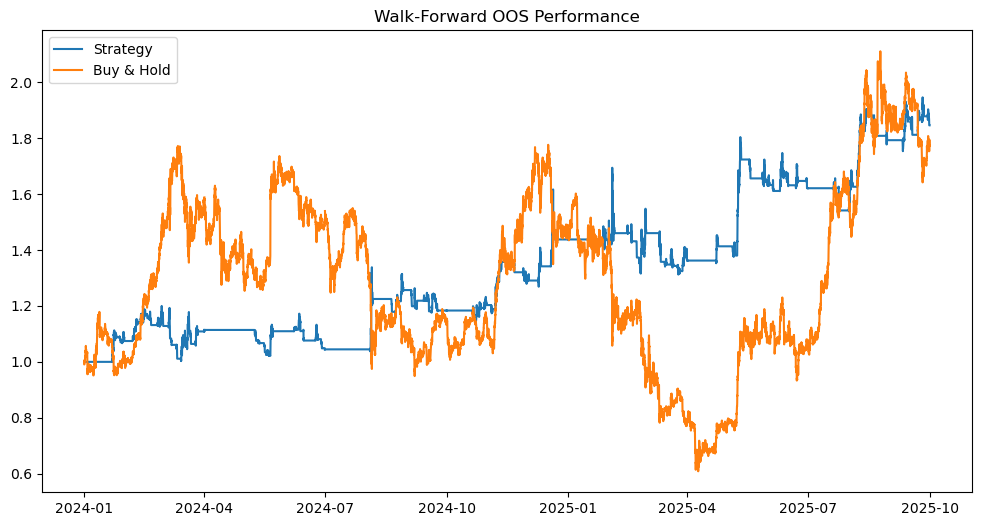

In [164]:
plt.figure(figsize=(12,6))
plt.plot(merged_oos.index, merged_oos['cumulative_strategy'], label='Strategy')
plt.plot(merged_oos.index, (1 + merged_oos['returns_1h']).cumprod(), label='Buy & Hold')
plt.legend()
plt.title('Walk-Forward OOS Performance')
plt.show()